In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pyvista
from cycler import cycler
#plt.rc('text', usetex=True)
#plt.rc('text.latex', preamble=r"\usepackage{amsmath}")
from loadingDynamicalData import *
import seaborn
import pickle
from scipy.interpolate import griddata
from matplotlib import cm

def reject_outliers(data, m = 4.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

## Version

To reproduce the results, The `CPC` tags of Kratos and ROM_AM should be installed. Using later/other versions can induce errors.

Previously trained ROMs are stored in the form of `.pkl` files in the `./trainedROMs` folder.
Those ROMs are constructed as described in this notebook, using Ubuntu 20.04 (X64), gcc 9.4.0 and Python 3.8.10. The `numpy` version is `1.22.4`.


# FSI Configuration

We consider the problem first illustrated below, where an incompressible flow in a $3D$ channel faces a massless elastic body with two mounted flaps.

!["setting"](./figs/double3Dschematic.png)

deformationFor the fluid, the Navier-Stokes equations read
\begin{equation}
    \begin{cases}
        \rho_f \dfrac{\partial \pmb{v}}{\partial t}_{|\tilde{\mathcal{A}}} + \rho_f [(\pmb{v} - \pmb{w}).\nabla]\pmb{v} + \nabla p - 2 \,\pmb{\text{div}}(\mu_f \pmb{D}(\pmb{v})) = 0 \quad \text{in}\ \Omega_f(t)\\[1.3ex]
        \nabla\cdot\pmb{v}= 0 \quad \text{in }\ \Omega_f(t)\\[1.3ex]
    \end{cases}    
\end{equation}

with $p$ the fluid pressure, $\rho_f$ the fluid density, $\mu_f$ the fluid dynamic viscosity and $\pmb{D}(\pmb{v})$ is the fluid strain rate tensor. The fluid equations are described on a moving domain (using the ALE moving frame) $\Omega_f(t)$. The notation $\tilde{\mathcal{A}}$ represents the ALE mapping from the reference domain (the $t=0$ configuration) to the computational domain and $\pmb{w}$ is the ALE velocity. 


The boundary faces corresponding to the top, bottom, back and front walls of the geometry in the left of the figure below will be called henceforward $y+$, $y-$, $z-$ and $z+$ respectively. To simplify the configuration, no cylinder is present in this problem but a fully developed pulsatile inlet flow is applied with a signal composed of two frequencies $(f_1, f_2)$, it's expressed as:
\begin{equation}
    \begin{cases}
        v_{|x=0}(y, t) = \frac{1}{2}(1-cos(\pi t)) g(y)\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \forall t \in [0, 1]\\
        v_{|x=0}(y, t) = \frac{1}{16}(16+(1-cos(2\pi(t-1)))) g(y)\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \forall t \in [1, 1.5]\\
        v_{|x=0}(y, t) = \frac{1}{16}(16+(cos(f_1\pi(t-1.5)))+(cos(f_2\pi(t-1.5)))) \,\,\,\, \forall t \in [1.5, 6.6]\\
        g(y) = 11.8\,y\,(0.492-y)
    \end{cases}
\end{equation}

with $\pmb{\mu}_1 = (f_1, f_2) = (4~Hz, 5~Hz)$ the parameter values used for training and $\pmb{\mu}_2 = (f_1, f_2) = 2~Hz, 3~Hz)$ for testing.
Slip conditions are used on the $z-$ and $z+$ faces, no-slip conditions are imposed on the $y-$ and $y+$ faces and a zero pressure is imposed on the outlet. The discretization uses 437039 elements with 84988 nodes. This flow setting corresponds to a Reynolds number $Re = 225$ based on the maximum inlet velocity and the length of the solid flap.


For the solid subproblem, the equilibrium and constitutive equations for a static hyperelastic solid are:

\begin{equation}
\begin{cases}
     \nabla_{\pmb{X}} \pmb{P} = \pmb{0} \quad \text{in}\; \Omega_{s} \\[1.3ex]
    \pmb{P} = \dfrac{\partial W}{\partial \pmb{F}_s} \\[1.3ex]
    \pmb{u} = \pmb{0} \; \quad \text{in}\; \Gamma_{D, s}\\[1.3ex]
\end{cases}  .
\end{equation}

The equations are written in the Lagrangian frame with $\nabla_{\pmb{X}}$ the gradient operator in the original configuration, $\pmb{P}$ is the first Piola-Kirchoff stress tensor (PK1) and $\Gamma_{D, s}$ is the Dirichlet boundary. The material model is described in the stored energy density function $W$, here using the hyperelastic Neo-Hookean model:
\begin{equation}
    W(\pmb{F}_s) =  \frac{\mu_s}{2}(trace(\pmb{C_s}) - 3)
\end{equation}
where $\pmb{C}_s = \pmb{F}_s^T \pmb{F}_s$ is the right Cauchy Green deformation tensor, $\mu_s = \dfrac{E}{2 (1 + \nu_s)}$ and $\lambda_s =\frac{E \nu_s}{(1 + \nu_s)(1 - 2  \nu_s)}$. 

For the solid material, a nearly-incompressible Neo-Hookean material is used with $\nu_s = 0.485$ and $E = 5 \times 10^6$ Pa. $\pmb{u}-\theta$ mixed tetrahedral elements are used where $\theta$ represents the Jacobian determinant  $J = det(\pmb{F}_s)$, $\theta = J \approx 1$. The mixed formulation is stabilized based on the VMS approach (See [1] for more details on the element used here).

The fluid problem is discretized using $5440$ variational multiscale (VMS) finite elements and $1640$ quadrilateral plane strain finite elements are used for the structural problem, with 8 ($X$ and $Y$) displacement degrees of freedom at element nodes, making a total of $N_S = 3610$ solid dofs. The second-order Bossak time integration is used by the fluid solver with a time step of $\Delta t = 0.01~s$. Similarly to the previous test case, matching interface grids are used, consisting of $7575$ nodes at the interface, giving $N = 22725$.

The mesh (`.mdpa`) files are located in `./meshData/`.

# Making the Reduced Order Models [[2]](#References)

![imgg](../../figs/CoupledClasses.png)

Data corresponding to the elastic tube simulation with $[f_1, f_2] = [4\;Hz,\;5\;Hz]$ was stored in the form of numpy arrays in the `trainingData/` folder. The simulation snapshots of solid displacement, fluid loads and the number of iterations per time step. Note that the data also contains the output of the intermediate subiterations, and not just the converged results.

In [2]:
# Loading the data as numpy arrays

disps = np.load("./trainingData/4_5/disp_data.npy")
loads = np.load("./trainingData/4_5/load_data.npy")

## Solid Displacement ROMs

The solid ROM can be constructed and trained using the `solid_ROM` class.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Quadratic manifolds for the displacement field reduction $r_u = 12$ retaining $99.99%$ of the energy.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;POD for load field reduction the $r_f = 280$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RBF interpolation with `thin_plate_spline` kernel functions.

In [3]:
from rom_am.solid_rom import solid_ROM
t0 = time.time()
sol_rom = solid_ROM()
sol_rom.train(loads, disps,
              rank_pres=280, rank_disp=.9999,
              regression_model="RBF",
              dispReduc_model="QUAD",
              forcesReduc_model="POD",
              map_used = np.load("./meshData/map_used.npy"),
              to_copy=[False, False],
              norm_regr=[False, True],
             norm = ["std", "l2"])
t1 = time.time()

# Free memory
del disps

In [4]:
print("Training wall time is ", t1 - t0, " s")

Training wall time is  65.02693963050842  s


## Solid Strain ROMs

Since the solid model here uses an incompressible mixed element, another ROM is needed for the additional degree of freedom (in this formulation associated to the nodes), representing the deformation Jacobian $\theta = J$. The same hyperparameters are used as those used in the displacement ROM.

In [5]:
# Loading the data as numpy arrays
strains = np.load("./trainingData/4_5/strain_data.npy")

In [6]:
t0 = time.time()
strain_ROM = solid_ROM()
strain_ROM.train(loads, strains,
              rank_pres=280, rank_disp=.9999,
              regression_model="RBF",
              dispReduc_model="QUAD",
              forcesReduc_model="POD",
              to_copy=[False, False],
              norm_regr=[False, True],
             norm = ["std", "l2"])
t1 = time.time()

# Free memory
del loads
del strains

## Fluid ROMs

The fluid ROM can be constructed and trained using the `FluidSurrog` class.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r_f = 70$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The solid `RomDimensionalityReducer` accessed through `sol_rom.dispReduc_model` is passed as an argument for the fluid ROM.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ridge regression with $\lambda = 1\times10^{-5}$ as a regularization prameter.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Retraining of the regressor is done after each $Z = 240$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The constant size of training batch is $p = 6900$.

In [7]:
trainiterDispData, trainRepflLoadDataConv, trainiterLoadData = bringDynamicalLoadDispData()

In [8]:
from rom_am.fluid_surrogate import FluidSurrog

fluidSurr = FluidSurrog(maxLen=6900, reTrainThres = 240)
fluidSurr.train(trainiterDispData, trainRepflLoadDataConv, trainiterLoadData,
                rank_pres=70,
                kernel='poly', degree = 1, smoothing=1e-5,
                solidReduc=sol_rom.dispReduc_model,
                norm=[False, False])

del trainiterDispData, trainRepflLoadDataConv, trainiterLoadData

 ----- Load Reduction -----
 ----- Displacement Reduction -----
 ----- Regression -----


The ROMs can be saved with `sol_rom.save("./trainedROMs/solidROM")`, `strain_ROM.save("./trainedROMs/strainROM")` and `fluidSurr.save("./trainedROMs/fluidSurrog")`, and then can be loaded for the simulation by indicating the object files in the [`./settingsDoubleFlap3D.json`](./settingsDoubleFlap3D.json) file.

# Simulation settings

The solid model parameters are defined in [`./ProjectParametersCSM.json`](./ProjectParametersCSM.json) and [`./StructuralMaterials.json`](./StructuralMaterials.json). The fluid model parameters in [`./ProjectParametersCFD.json`](./ProjectParametersCFD.json) and [`./FluidMaterials.json`](./FluidMaterials.json).

The coupling settings can be set in the [`./settingsDoubleFlap3D.json`](./settingsDoubleFlap3D.json) file.

<table>
<tr>
<th>Coupling parameter</th>
<th>Parameter choice</th>
<th>Associated hypermarameters</th>
</tr>
<tr>
<td>Coupling formulation</td>
<td>Accelerated Gauß-Seidel  $\mathcal{F}(\mathcal{S}(\boldsymbol{f})) = \boldsymbol{f}$</td>
<td>Tolerance $\epsilon = 5\times10^{-4}$</td>
</tr>
<tr>
<td>Convergence acceleration</td>
<td>IQN-ILS</td>
<td>$d=50$, $q=3$, $w_0=0.25$</td>
</tr>
<tr>
<td>Predictors</td>
<td>Constant *vs* Linear *vs* Quadratic *vs* Data-Driven</td>
<td>Tolerance $\epsilon_r = 1.10^{-4}$, $w_0=0.04$</td>
</tr>
</table>

The simulation results are saved in the `./coSimData/` folder, and the `vtk` files are saved in the `doubleFlap_CFD` and `doubleFlap_CSM` folders.

# Post-processing

The results of the pressure field, section area field, velocity field and number of iterations are stored in the `results/` folder.

**To replicate those results**, a `README` file inside each `results/` subfolder shows the `json`settings to be modified.

-------------------------------------------------------------------------------------------------------------

## Iteration results

We can show the accumulated number of iterations along the simulation time, comparing the efficacy of the classical predictors and the new data-driven predictor.

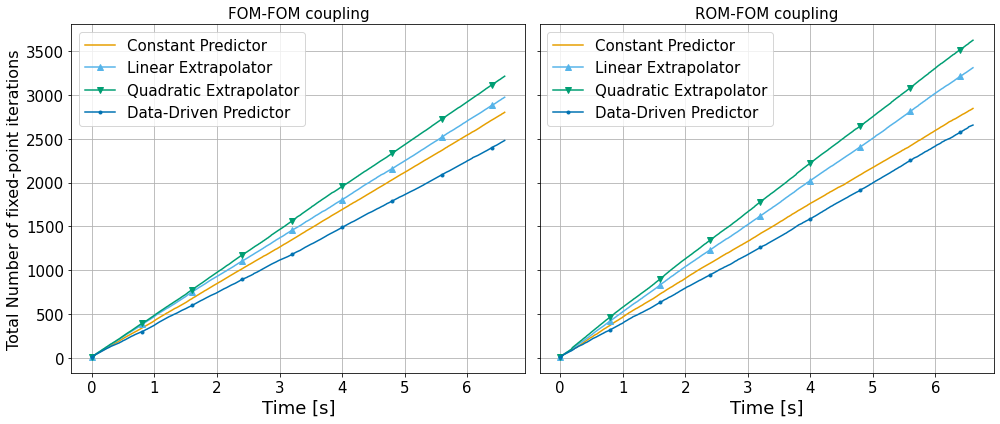

In [151]:
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "-","-","-","-","-","-",
                                  ],
                       marker=["", "^", "v", ".", "", "", ""],
                       markevery=[80, 80, 80, 80, 80, 80, 80]))


fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
ax[0].set_prop_cycle(line_cycler)
ax[1].set_prop_cycle(line_cycler)
time_ = np.arange(0.0, 6.61, 0.01)


ax[1].set_title("ROM-FOM coupling", fontsize = 15);
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/2_3/ConstantExtrapolation/coSimData/iters.npy")), label='Constant Predictor');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/2_3/LinearExtrapolation/coSimData/iters.npy")), label='Linear Extrapolator');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/2_3/QuadraticExtrapolation/coSimData/iters.npy")), label='Quadratic Extrapolator');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/2_3/SurrogatePrediction/coSimData/iters.npy")), label='Data-Driven Predictor');

ax[0].set_title("FOM-FOM coupling", fontsize = 15);
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/2_3/ConstantExtrapolation/coSimData/iters.npy")), label='Constant Predictor');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/2_3/LinearExtrapolation/coSimData/iters.npy")), label='Linear Extrapolator');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/2_3/QuadraticExtrapolation/coSimData/iters.npy")), label='Quadratic Extrapolator');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/2_3/SurrogatePrediction/coSimData/iters.npy")), label='Data-Driven Predictor');


ax[0].set_ylabel("Total Number of fixed-point iterations", fontsize = 16);
ax[0].set_xlabel("Time [s]", fontsize = 18);
ax[1].set_xlabel("Time [s]", fontsize = 18);
ax[0].legend(fontsize = 15);
ax[1].legend(fontsize = 15);

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)


ax[0].grid();
ax[1].grid();

plt.tight_layout();

More specifically, we can see the effect of the new predictors on the accuracy of the initial guess, measuring it using the residual of the FSI fixed point problem. An example is shown here below.

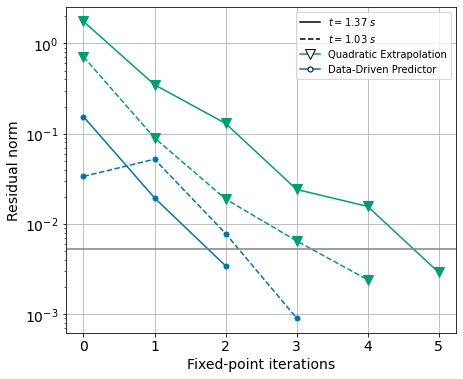

In [152]:
old = np.load("./results/FOM-FOM/2_3/ConstantExtrapolation/coSimData/residualInfo/iters.npy")
new = np.load("./results/FOM-FOM/2_3/SurrogatePrediction/coSimData/residualInfo/iters.npy")
res_size = np.sqrt(np.load("./results/FOM-FOM/2_3/ConstantExtrapolation/coSimData/residualInfo/rNorm.npy").shape[0])
min_= min(len(old), len(new))

line_cycler   = (cycler(color=["#009E73", "#0072B2", "#009E73", "#0072B2", "#0072B2", "#009E73"]) +
                 cycler(linestyle=["-", "-","--","--","-","--"],
                       marker=["v", ".", "v", ".", "", ""],
                       markevery=[1, 1, 1, 1, 1, 1],markersize = [10, 10, 10, 10, 10, 10]))

fig, ax = plt.subplots(figsize = (7, 6))
ax.set_prop_cycle(line_cycler)

increm = 137
#increm = np.random.randint(2, min_)
itersCurrentQuad_1 = old.cumsum()[increm]
itersCurrentQuad_0 = itersCurrentQuad_1 - old[increm]
itersCurrentSurr_1 = new.cumsum()[increm]
itersCurrentSurr_0 = itersCurrentSurr_1 - new[increm]
ax.semilogy(np.load("./results/FOM-FOM/2_3/ConstantExtrapolation/coSimData/residualInfo/rNorm.npy")[itersCurrentQuad_0:itersCurrentQuad_1]);
ax.semilogy(np.load("./results/FOM-FOM/2_3/SurrogatePrediction/coSimData/residualInfo/rNorm.npy")[itersCurrentSurr_0:itersCurrentSurr_1]);
firsT = str(increm*0.01)

increm = 103
itersCurrentQuad_1 = old.cumsum()[increm]
itersCurrentQuad_0 = itersCurrentQuad_1 - old[increm]
itersCurrentSurr_1 = new.cumsum()[increm]
itersCurrentSurr_0 = itersCurrentSurr_1 - new[increm]
ax.semilogy(np.load("./results/FOM-FOM/2_3/ConstantExtrapolation/coSimData/residualInfo/rRelNorm.npy")[itersCurrentQuad_0:itersCurrentQuad_1]);
ax.semilogy(np.load("./results/FOM-FOM/2_3/SurrogatePrediction/coSimData/residualInfo/rRelNorm.npy")[itersCurrentSurr_0:itersCurrentSurr_1]);
secondT = str(increm*0.01)


ax.set_xlabel("Fixed-point iterations", fontsize = 14);
ax.set_ylabel("Residual norm", fontsize = 14);
color = np.array([["#E69F00", "#56B4E9"],]*2).transpose()  # Can be other colours than b,g,r
marker0 = ['-', '--']
marker = ['v-', '.-']

# legend
label_column = ['Quadratic Extrapolation','Data-Driven Predictor']
label_row = [r'$t='+firsT+'~s$', r'$t='+secondT+'~s$']
rows = [plt.plot([], [], marker0[i], color='k')[0] for i in range(2)]
columns = [plt.plot([], [], marker[i], markerfacecolor='w',
                    markeredgecolor='k')[0] for i in range(2)]
plt.legend(rows + columns, label_row + label_column, loc='best')
ax.axhline(1e-4*res_size, color='grey');
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)

plt.grid();

But "How typical are the examples given in the figure above ?".
To answer this question, we can show the distribution of:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- The differences in the number $\Delta{N_{k}^n}$ of iterations at each time step $n$, where $\Delta{N_{k}^n} = N_{k, \text{REF}}^n - N_{k, \text{DD}}$, with $N_{k, \text{REF}}^n$ is the number of iterations-to-convergence with the classical predictors (here comparing the quadratic and constant extrapolations) and $N_{k, \text{DD}}^n$ is the number of iterations-to-convergence using the new data-driven predictor. The occurrence of the $\Delta{N_{k}}^n$ quantities greater than $0$ are indicating a performance gain with the new predictors.
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- he ratios of the initial residuals $\zeta^n$ at each time step $n$, where $\zeta^n = ||\boldsymbol{r}_{\text{REF}}^0||_2^n \;/\; ||\boldsymbol{r}_{\text{DD}}^0||_2^n$. The occurrence of the $\zeta^n$ quantities greater than $1$ are indicating a performance gain with the new predictors.    

In [23]:
surrIters = np.load("results/FOM-FOM/2_3/SurrogatePrediction/coSimData/residualInfo/iters.npy")
surrFirstIterIndices = (surrIters.cumsum() - surrIters)
surrInitialResiduals = np.load("results/FOM-FOM/2_3/SurrogatePrediction/coSimData/residualInfo/rNorm.npy")[surrFirstIterIndices]

quadIters = np.load("results/FOM-FOM/2_3/QuadraticExtrapolation/coSimData/residualInfo/iters.npy")
quadFirstIterIndices = (quadIters.cumsum() - quadIters)
quadInitialResiduals = np.load("results/FOM-FOM/2_3/QuadraticExtrapolation/coSimData/residualInfo/rNorm.npy")[quadFirstIterIndices]

Iters = np.load("results/FOM-FOM/2_3/ConstantExtrapolation/coSimData/residualInfo/iters.npy")
FirstIterIndices = (Iters.cumsum() - Iters)
InitialResiduals = np.load("results/FOM-FOM/2_3/ConstantExtrapolation/coSimData/residualInfo/rNorm.npy")[FirstIterIndices]


differences1 = quadInitialResiduals - surrInitialResiduals
differences2 = quadIters - surrIters
divisions1 = quadInitialResiduals/surrInitialResiduals

differences1ref = InitialResiduals - surrInitialResiduals
differences2ref = Iters - surrIters
divisions1ref = InitialResiduals/surrInitialResiduals

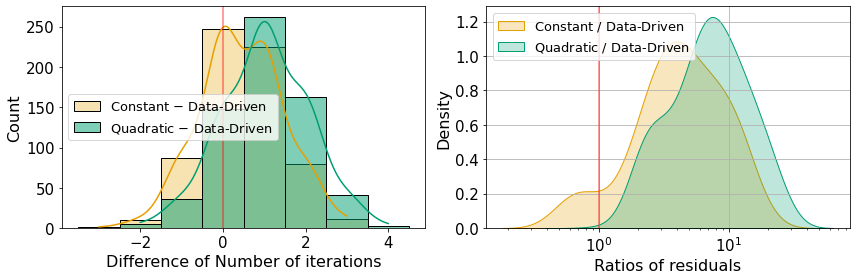

In [148]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4));
plot_data = {'Constant $-$ Data-Driven': reject_outliers(differences2ref), }
g = seaborn.histplot(plot_data['Constant $-$ Data-Driven'], discrete=True,
                     label = 'Constant $-$ Data-Driven', ax = ax[0],
                     color='#E69F00', fill = True, alpha=.3,
                     kde=True, kde_kws={"bw_adjust":1.6});


plot_data = {'Quadratic $-$ Data-Driven': reject_outliers(differences2), }
h = seaborn.histplot(plot_data['Quadratic $-$ Data-Driven'], discrete=True,
                     label = 'Quadratic $-$ Data-Driven', ax = ax[0],
                     color='#009E73', fill = True,
                     kde=True, kde_kws={"bw_adjust":1.6});

ax[0].set_xlabel('Difference of Number of iterations', fontsize=16);
ax[0].set_ylabel('Count', fontsize=16);
ax[0].axvline(0, color='red', alpha = 0.5);
ax[0].legend(fontsize=13);
ax[0].tick_params(axis='both', which='major', labelsize = 15);



plot_data = reject_outliers(divisions1ref, m=3)
seaborn.kdeplot(data=plot_data,
            fill=True, bw_adjust=1.6, gridsize=2000, ax=ax[1],
                log_scale=True, color="#E69F00",label=r'Constant $/$ Data-Driven'
               );

plot_data = {'Quadratic $/$ Data-Driven': reject_outliers(divisions1, m=3)}
seaborn.kdeplot(data=plot_data['Quadratic $/$ Data-Driven'], ax = ax[1],
            fill=True, bw_adjust=1.6, gridsize=2000,
                log_scale=True, color='#009E73', label=r'Quadratic $/$ Data-Driven'
              );
ax[1].legend(loc='upper left', fontsize=13);
ax[1].set_xlabel("Ratios of residuals", fontsize=16);
ax[1].axvline(1, color = 'red', alpha = 0.5);
ax[1].set_ylabel('Density', fontsize=16);
ax[1].grid();
ax[1].tick_params(axis='both', which='major', labelsize = 15);

plt.tight_layout();

# References

[1] [Guglielmo Scovazzi, Rubén Zorrilla, Riccardo Rossi, A kinematically stabilized linear tetrahedral finite element for compressible and nearly incompressible finite elasticity, CMAME, Volume 412, 2023, 116076, ISSN 0045-7825,](https://doi.org/10.1016/j.cma.2023.116076)

[2] [Azzeddine Tiba, Thibault Dairay, Florian De Vuyst, Iraj Mortazavi, Juan-Pedro Berro Ramirez (2024). Machine-Learning Enhanced Predictors for Accelerated Convergence of Partitioned Fluid-Structure Interaction Simulations. arXiv preprint arXiv:2405.09941](https://doi.org/10.48550/arXiv.2405.09941)
